# Evaluation of target priority as a function of time

MOP currently as two algorithms which determine the priority that a target should receive for observations, one aimed at stellar events and the other at long-timescale events. 

The goal of this notebook is to evaluate how well these algorithms perform for real-world data. 

In [41]:
from os import path
from astropy.table import Table, Column
from astropy.time import Time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

First let's define some commonly needed functions for later use.

In [38]:
def load_csv_lightcurve(lc_file):
    if not path.isfile(lc_file):
        raise IOError('Cannot find input file at ' + lc_file)

    with open(lc_file, mode ='r') as file:
        lines = file.readlines()
        data = []
        source = None
        passband = None
        for line in lines[1:]:
            entries = line.replace('\n','').split(',')
            if not source:
                source = entries[2]
            if not passband:
                passband = entries[7]
            data.append([
                Time(entries[4],format='isot').mjd, 
                float(entries[8]), 
                float(entries[6])
            ])
        data = np.array(data)
        
    return data, source, passband
    

## Target priority functions

During a follow-up observing campaign, we need to evaluate each event using all of the data on that event that are available up to the present time.  The priority then needs to be re-evaluated as soon as more data come in. 
We can therefore calculate the priority on a per-datapoint basis.  

MOP uses the functions below to calculate this priority.

In [47]:
def TAP_long_event_priority(t_now, t_last, t_E, t_E_base = 75.):
    """
    This function calculates priority of a long microlensing event.
    If the event has a timescale equal to t_E_base, and was not
    observed for t_obs_gap days, the priority should be close to 10.
    If the event was not observed for more than 10 days,
    the priority is boosted by 10.
    If the fit was bad (indicated by t_E being a NaN), than
    the priority drops to 0.
    Inspired by Horn et al. 2009.

    :param t_now: current JD
    :param t_last: JD of the latest datapoint in any lightcurve
                    assigned to the dataset
    :param t_E: Einstein timescale of the event
    :param t_E_base: cutoff point for long tE event

    :return: priority of the long microlensing event
    """

    # Catch invalid input
    if np.isnan(t_E) or t_E == 0.0:
        return 0.0

    if (np.isnan(t_E)):
        # t_E may hit the fit bounds. This means, the fit was
        # wrong. In this case the event should not be observed
        # and wait for a better estimate of the values.
        psi = np.nan
    else:
        t_obs_gap = 2.

        # Events with t_E of t_E_base days will have priority 10.
        psi = t_E / t_E_base

        # If the event was not observed for t_obs_gap days the priority
        # should rise.
        delta_t = t_now - t_last
        x = (delta_t / t_obs_gap) - t_obs_gap
        psi *= 10. / (1. + np.exp(-x))

        # KK: Boosting turned off, short timescale events were promoted.
        # The event priority should be boosted if it was not
        # observed for more than 10 days and it is a long event.
        # if (delta_t > 10.):
        #     psi *= 10.

    # Intercept NaN values and set them to zero as NaN entries
    # are non-retrievable from the DB
    if np.isnan(psi):
        psi = 0.0

    return psi

def TAP_long_event_priority_error(t_E, covariance, t_E_base = 75.):
    """
    This function calculates error of the priority
    of a long microlensing event.

    :param t_E: Einstein timescale of the event
    :param covariance: covariance matrix
    :param t_E_base: cutoff point for long tE event

    :return: error of the priority of the long microlensing event.
    """

    # Catch invalid input
    if len(covariance) == 0 or np.isnan(t_E):
        return 0.0

    if(np.isnan(t_E)):
        err_psi = 0.
    else:
        # Simple derevative
        err_t_E = np.sqrt(covariance[2,2])
        err_psi = 10. *  err_t_E / t_E_base

    # Intercept NaN values and set them to zero as NaN entries
    # are non-retrievable from the DB
    if np.isnan(err_psi):
        err_psi = 0.0

    return err_psi

In [48]:
def TAP_planet_priority(time_now, t0_pspl, u0_pspl, tE_pspl):
    """
    This function calculates the priority for ranking
    microlensing events based on the planet probability psi
    as defined by Dominik 2009 and estimates the cost of
    observations based on an empiric RMS estimate
    obtained from a DANDIA reduction of K2C9 Sinistro
    observations from 2016. It expects the overhead to be
    60 seconds and also return the current Paczynski
    light curve magnification.
    """

    # Catch invalid input
    if np.isnan(t0_pspl) or np.isnan(u0_pspl) or np.isnan(tE_pspl) \
            or t0_pspl == 0.0 or tE_pspl == 0.0:
        return 0.0

    usqr = u0_pspl**2 + ((time_now - t0_pspl) / tE_pspl)**2
    pspl_deno = (usqr * (usqr + 4.))**0.5
    if pspl_deno < 1e-10:
        pspl_deno = 10000.
    psip = 4.0 / (pspl_deno) - 2.0 / (usqr + 2.0 + pspl_deno)

    # Intercept NaN values and set them to zero as NaN entries
    # are non-retrievable from the DB
    if np.isnan(psip):
        psip = 0.0

    return psip

def TAP_planet_priority_error(time_now, t0_pspl, u0_pspl, tE_pspl, covariance):
    """
    This function calculates the priority for ranking
    microlensing events based on the planet probability psi
    as defined by Dominik 2009 and estimates the cost of
    observations based on an empiric RMS estimate
    obtained from a DANDIA reduction of K2C9 Sinistro
    observations from 2016. It expects the overhead to be
    60 seconds and also return the current Paczynski
    light curve magnification.
    """

    # Catch invalid input
    if len(covariance) == 0 or np.isnan(t0_pspl) or np.isnan(u0_pspl) or np.isnan(tE_pspl):
        return 0.0

    usqr = u0_pspl**2 + ((time_now - t0_pspl) / tE_pspl)**2

    dpsipdu = -8*(usqr+2)/(usqr*(usqr+4)**1.5)
    dpsipdu += 4*(usqr**0.5*(usqr+4)**0.5+usqr+2)/(usqr+2+(usqr+4)**0.5)**2*1/(usqr+4)**0.5

    dUdto = -(time_now - t0_pspl) / (tE_pspl ** 2 *usqr**0.5)
    dUduo = u0_pspl/ usqr**0.5
    dUdtE = -(time_now - t0_pspl) ** 2 / (tE_pspl ** 3 * usqr**0.5)

    print(covariance, dpsipdu, dUdto, dUdtE, dUduo)
    Jacob = np.zeros(len(covariance))
    Jacob[0] = dpsipdu*dUdto
    Jacob[1] = dpsipdu*dUduo
    Jacob[2] = dpsipdu*dUdtE

    error_psip = np.dot(Jacob.T,np.dot(covariance,Jacob))**0.5

    # Intercept NaN values and set them to zero as NaN entries
    # are non-retrievable from the DB
    if np.isnan(error_psip):
        error_psip = 0.0

    return error_psip #/ (calculate_exptime_omega_sdss_i(mag) + 60.)

These functions depend on determining the parameters of the best-fit microlensing model to all available data up to each datapoint. To evaluate how these priority functions perform as a function of time throughout an event's lightcurve, we therefore need to effectively 'drip-feed' the lightcurve data one datapoint at a time, re-model the event and recalculate the priority for each timestamp. 

## Event Model Fitting

We use PyLIMA to model microlensing events.  For the purposes of this investigation, we will consider the simple case of a Point-Source, Point-Lens model without parallax, and define a function to perform this fit and return the resulting model parameters. 

In [ ]:
def fit_pspl_model(event_data):
    """
    Function to fit a PSPL microlensing model to the timeseries photometry for a single event

    Parameters:
       event_data dict {'ra': Right Ascention in decimal degrees,
                        'dec': Declination in decimal degrees,
                        'lc': Numpy array with single survey lightcurves, with columns HJD, mag, mag_error
    """



## Stellar event example: OGLE-2024-GD-0013

To start with, let's load the survey photometry of a typical stellar lens event.

In [39]:
# Path to the input lightcurve file in the format downloaded from MOP's photometry table for this event
lc_file = '/Users/rstreet/OMEGAII/Data/OGLE-2024-GD-0013/ogle-2024-gd-0013.csv'

data, source, passband = load_csv_lightcurve(lc_file)
print(data)
print('Data origin: ' + source + ', filter ' + passband)

[[5.64382318e+04 1.97490000e+01 2.14000000e-01]
 [5.64652106e+04 1.95580000e+01 1.71000000e-01]
 [5.65200126e+04 1.98150000e+01 2.11000000e-01]
 ...
 [6.05359710e+04 1.89510000e+01 1.22000000e-01]
 [6.05370675e+04 1.90030000e+01 1.32000000e-01]
 [6.05450310e+04 1.93100000e+01 1.44000000e-01]]
Data origin: OGLE, filter OGLE_I


(np.float64(56232.89180699994),
 np.float64(60750.3709930002),
 np.float64(20.871299999999998),
 np.float64(18.1587))

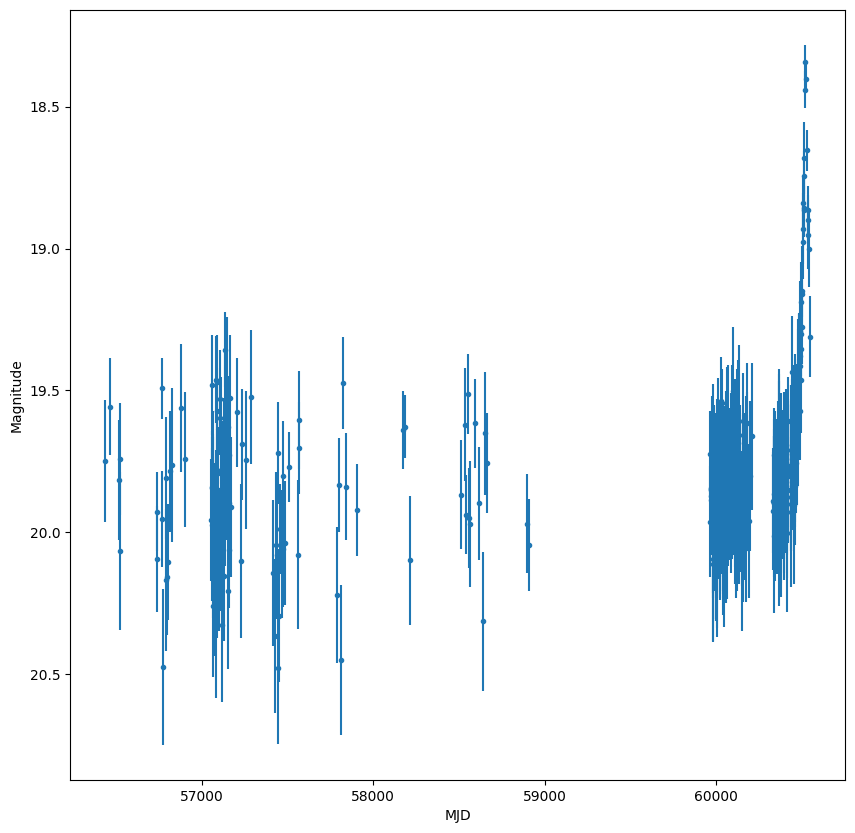

In [45]:
fig = plt.figure(1, (10,10))

plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='.')
plt.xlabel('MJD')
plt.ylabel('Magnitude')
[xmin,xmax,ymin,ymax] = plt.axis()
plt.axis([xmin,xmax,ymax,ymin])